# MLP on Simulated ORFs  
Start with ORF_MLP_118 which had the simulator bug fix.  
Evaluate MLP with wide,deep network.  
Train on copious simulated data.  
Use uniform but longer RNA lengths: 1500   
Run on Alien.
79% accuracy.

In [1]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-08-17 15:18:15 EDT


In [2]:
PC_TRAINS=50000
NC_TRAINS=50000
PC_TESTS=5000
NC_TESTS=5000   
RNA_LEN=1500  
MAX_K = 3 
INPUT_SHAPE=(None,84)  # 4^3 + 4^2 + 4^1
NEURONS=128
DROP_RATE=0.30
EPOCHS=200
SPLITS=3
FOLDS=3   # make this 5 for serious testing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

2021-08-17 15:18:16.281332: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [4]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from GenCodeTools import Collection_Generator,Transcript_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/DataPrep.py')
    with open('DataPrep.py', 'w') as f:
        f.write(r.text)  
    from DataPrep import DataPrep
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter
        from SimTools.RNA_gen import Collection_Generator,Transcript_Oracle
        from SimTools.KmerTools import KmerTools
        from SimTools.DataPrep import DataPrep
BESTMODELPATH=DATAPATH+"BestModel"  
LASTMODELPATH=DATAPATH+"LastModel"  

CoLab not working. On my PC, use relative paths.


## Data Load


In [5]:
show_time()
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    pcgen.set_seq_oracle(Transcript_Oracle())
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen

pc_sim,nc_sim = make_generators(RNA_LEN)
pc_all = pc_sim.get_sequences(PC_TRAINS+PC_TESTS)
nc_all = nc_sim.get_sequences(NC_TRAINS+NC_TESTS)
print("Generated",len(pc_all),"PC seqs")
print("Generated",len(nc_all),"NC seqs")
pc_sim=None
nc_sim=None

2021-08-17 15:18:16 EDT
Generated 55000 PC seqs
Generated 55000 NC seqs


In [6]:
print("Simulated sequence characteristics:")
oc = ORF_counter()
print("PC seqs")
oc.describe_sequences(pc_all)
print("NC seqs")
oc.describe_sequences(nc_all)
oc=None
show_time()

Simulated sequence characteristics:
PC seqs
Average RNA length: 1500.0
Average ORF length: 1010.1346363636363
NC seqs
Average RNA length: 1500.0
Average ORF length: 208.8883090909091
2021-08-17 15:18:49 EDT


## Data Prep

In [7]:
dp = DataPrep()
Xseq,y=dp.combine_pos_and_neg(pc_all,nc_all)
nc_all=None
pc_all=None
nc_all=None
print("The first few shuffled labels:")
print(y[:30])
show_time()

The first few shuffled labels:
[0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0]
2021-08-17 15:18:49 EDT


In [8]:
Xfrq=KmerTools.seqs_to_kmer_freqs(Xseq,MAX_K)
Xseq = None
y=np.asarray(y)
show_time()

2021-08-17 15:19:20 EDT


In [9]:
# Assume X and y were shuffled.
train_size=PC_TRAINS+NC_TRAINS
X_train=Xfrq[:train_size] 
X_test=Xfrq[train_size:]
y_train=y[:train_size] 
y_test=y[train_size:]
print("Training set size=",len(X_train),"=",len(y_train))
print("Reserved test set size=",len(X_test),"=",len(y_test))
Xfrq=None
y=None
show_time()

Training set size= 100000 = 100000
Reserved test set size= 10000 = 10000
2021-08-17 15:19:20 EDT


## Neural network

In [10]:
def make_DNN():
    dt=np.float32
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt))  
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=dt))   
    dnn.compile(optimizer='adam',    
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 84)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               10880     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)        

2021-08-17 15:19:20.126318: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-17 15:19:20.169154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-17 15:19:20.169973: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-17 15:19:20.170033: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-17 15:19:20.176235: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-17 15:19:20.176334: I tensorflow/stream_executor

In [11]:
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=BESTMODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    # When shuffle=True, the valid indices are a random subset.
    # No need to shuffle here assuming data was shuffled above.
    splitter = KFold(n_splits=SPLITS,shuffle=False) 
    model = None
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()
    return model  # parameters at end of training

2021-08-17 15:19:20 EDT
MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200


2021-08-17 15:19:20.705662: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-17 15:19:20.724750: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2496000000 Hz
2021-08-17 15:19:27.093046: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


 156/2084 [=>............................] - ETA: 1s - loss: 0.7428 - accuracy: 0.4919 

2021-08-17 15:19:27.410822: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


2084/2084 [==============================] - 9s 1ms/step - loss: 0.7082 - accuracy: 0.4983 - val_loss: 0.6931 - val_accuracy: 0.5027


2021-08-17 15:19:30.388575: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 2/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6935 - accuracy: 0.4991 - val_loss: 0.6931 - val_accuracy: 0.5027
Epoch 3/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6933 - accuracy: 0.5018 - val_loss: 0.6931 - val_accuracy: 0.5027
Epoch 4/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6931 - accuracy: 0.5061 - val_loss: 0.6930 - val_accuracy: 0.5027
Epoch 5/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6902 - accuracy: 0.5232 - val_loss: 0.6469 - val_accuracy: 0.6546
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 6/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6593 - accuracy: 0.6067 - val_loss: 0.5984 - val_accuracy: 0.7407
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 7/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6337 - accuracy: 0.6407 -

2084/2084 [==============================] - 3s 1ms/step - loss: 0.4973 - accuracy: 0.7590 - val_loss: 0.4566 - val_accuracy: 0.7874
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 49/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4943 - accuracy: 0.7574 - val_loss: 0.4590 - val_accuracy: 0.7878
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 50/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4961 - accuracy: 0.7568 - val_loss: 0.4622 - val_accuracy: 0.7826
Epoch 51/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4941 - accuracy: 0.7592 - val_loss: 0.4597 - val_accuracy: 0.7881
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 52/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4941 - accuracy: 0.7595 - val_loss: 0.4560 - val_accuracy: 0.7881
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 53/200
2084/2084 [==============================]

Epoch 101/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4779 - accuracy: 0.7705 - val_loss: 0.4512 - val_accuracy: 0.7886
Epoch 102/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4779 - accuracy: 0.7700 - val_loss: 0.4506 - val_accuracy: 0.7890
Epoch 103/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4806 - accuracy: 0.7679 - val_loss: 0.4517 - val_accuracy: 0.7889
Epoch 104/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4764 - accuracy: 0.7716 - val_loss: 0.4534 - val_accuracy: 0.7886
Epoch 105/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4793 - accuracy: 0.7699 - val_loss: 0.4499 - val_accuracy: 0.7885
Epoch 106/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4747 - accuracy: 0.7714 - val_loss: 0.4501 - val_accuracy: 0.7886
Epoch 107/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4759 - accuracy: 0.7677 - val_loss: 0

Epoch 155/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4736 - accuracy: 0.7712 - val_loss: 0.4512 - val_accuracy: 0.7876
Epoch 156/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4692 - accuracy: 0.7755 - val_loss: 0.4525 - val_accuracy: 0.7872
Epoch 157/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4769 - accuracy: 0.7700 - val_loss: 0.4504 - val_accuracy: 0.7888
Epoch 158/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4693 - accuracy: 0.7764 - val_loss: 0.4569 - val_accuracy: 0.7843
Epoch 159/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4719 - accuracy: 0.7743 - val_loss: 0.4499 - val_accuracy: 0.7884
Epoch 160/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4716 - accuracy: 0.7725 - val_loss: 0.4500 - val_accuracy: 0.7884
Epoch 161/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4694 - accuracy: 0.7733 - val_loss: 0

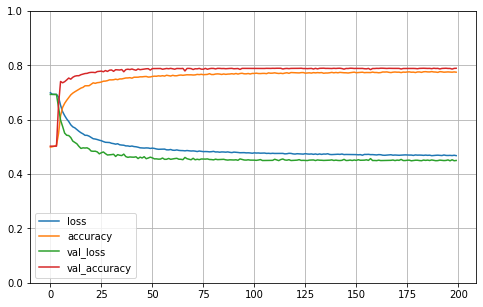

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.7085 - accuracy: 0.5008 - val_loss: 0.6936 - val_accuracy: 0.4980
Epoch 2/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6935 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4980
Epoch 3/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6933 - accuracy: 0.5003 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 4/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4980
Epoch 5/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6930 - val_accuracy: 0.5020
Epoch 6/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6920 - accuracy: 0.5136 - val_loss: 0.6643 - val_accuracy: 0.5782
Epoch 7/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6620 - a

Epoch 57/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4845 - accuracy: 0.7660 - val_loss: 0.4659 - val_accuracy: 0.7794
Epoch 58/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4873 - accuracy: 0.7637 - val_loss: 0.4630 - val_accuracy: 0.7799
Epoch 59/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4859 - accuracy: 0.7648 - val_loss: 0.4652 - val_accuracy: 0.7812
Epoch 60/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4874 - accuracy: 0.7660 - val_loss: 0.4619 - val_accuracy: 0.7825
Epoch 61/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4826 - accuracy: 0.7668 - val_loss: 0.4605 - val_accuracy: 0.7812
Epoch 62/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4844 - accuracy: 0.7683 - val_loss: 0.4646 - val_accuracy: 0.7820
Epoch 63/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4846 - accuracy: 0.7671 - val_loss: 0.4624 -

2084/2084 [==============================] - 3s 1ms/step - loss: 0.4755 - accuracy: 0.7705 - val_loss: 0.4569 - val_accuracy: 0.7835
Epoch 114/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4709 - accuracy: 0.7745 - val_loss: 0.4578 - val_accuracy: 0.7816
Epoch 115/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4702 - accuracy: 0.7740 - val_loss: 0.4597 - val_accuracy: 0.7830
Epoch 116/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4718 - accuracy: 0.7751 - val_loss: 0.4570 - val_accuracy: 0.7844
Epoch 117/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4753 - accuracy: 0.7717 - val_loss: 0.4571 - val_accuracy: 0.7835
Epoch 118/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4745 - accuracy: 0.7724 - val_loss: 0.4568 - val_accuracy: 0.7838
Epoch 119/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4726 - accuracy: 0.7726 - val_loss: 0.4565 - val_ac

Epoch 169/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4670 - accuracy: 0.7783 - val_loss: 0.4561 - val_accuracy: 0.7828
Epoch 170/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4656 - accuracy: 0.7782 - val_loss: 0.4566 - val_accuracy: 0.7838
Epoch 171/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4688 - accuracy: 0.7780 - val_loss: 0.4585 - val_accuracy: 0.7831
Epoch 172/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4653 - accuracy: 0.7778 - val_loss: 0.4562 - val_accuracy: 0.7839
Epoch 173/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4647 - accuracy: 0.7801 - val_loss: 0.4590 - val_accuracy: 0.7832
Epoch 174/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4721 - accuracy: 0.7740 - val_loss: 0.4558 - val_accuracy: 0.7829
Epoch 175/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4659 - accuracy: 0.7755 - val_loss: 0

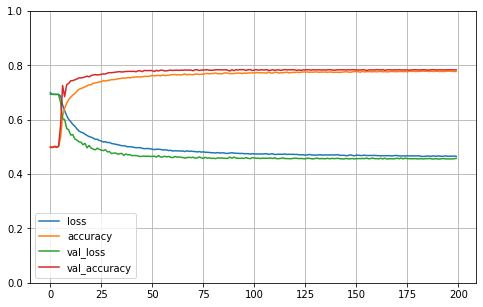

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.7062 - accuracy: 0.5033 - val_loss: 0.6932 - val_accuracy: 0.5012
Epoch 2/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6937 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 3/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6932 - val_accuracy: 0.5012
Epoch 4/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5026 - val_loss: 0.6927 - val_accuracy: 0.4988
Epoch 5/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6891 - accuracy: 0.5288 - val_loss: 0.6239 - val_accuracy: 0.7250
Epoch 6/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6558 - accuracy: 0.6081 - val_loss: 0.6073 - val_accuracy: 0.7093
Epoch 7/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6341 - a

Epoch 57/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4903 - accuracy: 0.7651 - val_loss: 0.4593 - val_accuracy: 0.7833
Epoch 58/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4838 - accuracy: 0.7675 - val_loss: 0.4603 - val_accuracy: 0.7817
Epoch 59/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4858 - accuracy: 0.7634 - val_loss: 0.4598 - val_accuracy: 0.7833
Epoch 60/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4870 - accuracy: 0.7638 - val_loss: 0.4606 - val_accuracy: 0.7812
Epoch 61/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4855 - accuracy: 0.7650 - val_loss: 0.4581 - val_accuracy: 0.7835
Epoch 62/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4894 - accuracy: 0.7646 - val_loss: 0.4580 - val_accuracy: 0.7836
Epoch 63/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4894 - accuracy: 0.7644 - val_loss: 0.4569 -

2084/2084 [==============================] - 3s 1ms/step - loss: 0.4787 - accuracy: 0.7710 - val_loss: 0.4562 - val_accuracy: 0.7840
Epoch 114/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4744 - accuracy: 0.7739 - val_loss: 0.4541 - val_accuracy: 0.7843
Epoch 115/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4725 - accuracy: 0.7744 - val_loss: 0.4545 - val_accuracy: 0.7847
Epoch 116/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4744 - accuracy: 0.7708 - val_loss: 0.4545 - val_accuracy: 0.7841
Epoch 117/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4710 - accuracy: 0.7753 - val_loss: 0.4537 - val_accuracy: 0.7844
Epoch 118/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4728 - accuracy: 0.7750 - val_loss: 0.4531 - val_accuracy: 0.7843
Epoch 119/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4684 - accuracy: 0.7776 - val_loss: 0.4560 - val_ac

Epoch 169/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4680 - accuracy: 0.7758 - val_loss: 0.4531 - val_accuracy: 0.7850
Epoch 170/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4678 - accuracy: 0.7771 - val_loss: 0.4527 - val_accuracy: 0.7847
Epoch 171/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4677 - accuracy: 0.7780 - val_loss: 0.4535 - val_accuracy: 0.7850
Epoch 172/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4683 - accuracy: 0.7745 - val_loss: 0.4537 - val_accuracy: 0.7839
Epoch 173/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4702 - accuracy: 0.7741 - val_loss: 0.4529 - val_accuracy: 0.7852
Epoch 174/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4685 - accuracy: 0.7759 - val_loss: 0.4532 - val_accuracy: 0.7853
Epoch 175/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4697 - accuracy: 0.7772 - val_loss: 0

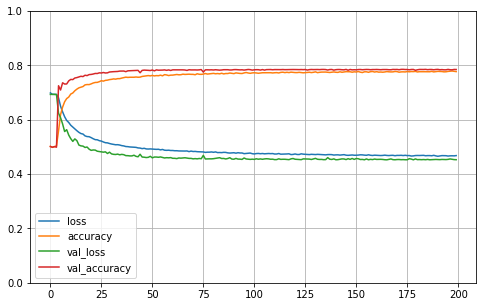

In [12]:
show_time()
last_model = do_cross_validation(X_train,y_train)
best_model = load_model(BESTMODELPATH)

In [14]:
def show_test_AUC(model,X,y):
    ns_probs = [0 for _ in range(len(y))]
    bm_probs = model.predict(X)
    ns_auc = roc_auc_score(y, ns_probs)
    bm_auc = roc_auc_score(y, bm_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
    plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print("%s: %.2f%%" %('AUC',bm_auc*100.0))
def show_test_accuracy(model,X,y):
    scores = model.evaluate(X, y, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Accuracy on training data.
2021-08-17 15:52:55 EDT


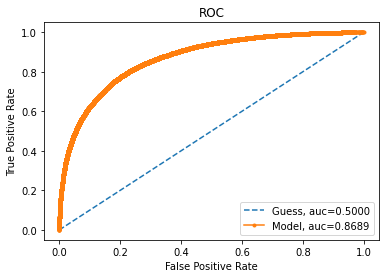

AUC: 86.89%
accuracy: 78.62%
2021-08-17 15:52:58 EDT


In [15]:
print("Accuracy on training data.")
show_time()
show_test_AUC(best_model,X_train,y_train)
show_test_accuracy(best_model,X_train,y_train)
show_time()

Accuracy on test data.
2021-08-17 15:52:58 EDT


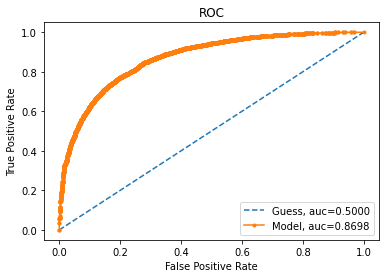

AUC: 86.98%
accuracy: 78.55%
2021-08-17 15:52:58 EDT


In [16]:
print("Accuracy on test data.")
show_time()
show_test_AUC(last_model,X_test,y_test)
show_test_accuracy(best_model,X_test,y_test)
show_time()